In [2]:
# Bibliotecas ----
import os
import json
import requests
from langchain_community.document_loaders import WebBaseLoader
from langchain.docstore.document import Document
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain.chains.combine_documents.stuff import StuffDocumentsChain
import pandas as pd
import plotnine as p9

In [4]:
# Autenticação na API do Google
os.environ["GOOGLE_API_KEY"] = open('passgooglestudio.txt', 'r').read()

In [5]:
# Coleta de dados ----
ultima_ata = requests.get(
  "https://www.bcb.gov.br/api/servico/sitebcb/copom/atas?quantidade=1"
  ).json()["conteudo"][0]["nroReuniao"]

url_ata = "https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao="

documentos = []
for num in list(range(252, ultima_ata + 1)):
    url_completa = url_ata + str(num)
    ata = WebBaseLoader(f"{url_ata}{num}").load()
    print(f"{url_ata}{num}")
    conteudo = json.loads(ata[0].page_content)["conteudo"][0]
    documentos.append(
        Document(
            page_content = conteudo["textoAta"],
            metadata = {"data": conteudo["dataReferencia"]}
        )
    )

https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao=252
https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao=253
https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao=254
https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao=255
https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao=256
https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao=257
https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao=258
https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao=259
https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao=260
https://www.bcb.gov.br/api/servico/sitebcb/copom/atas_detalhes?nro_reuniao=261


In [6]:
# Modelagem ----

# Definição do modelo LLM
llm = ChatGoogleGenerativeAI(model = "gemini-pro", temperature = 0)

# Engenharia de prompt
llm_prompt = PromptTemplate.from_template("""
Você é um cientista de dados experiente em machine learning e em NLP, dominando
as técnicas de análise de sentimentos. Sua tarefa é analisar o sentimento do
texto a seguir. Retorne o sentimento do texto em um índice de 0 a 100, sendo 0 o
sentimento mais negativo, 100 o sentimento mais positivo e 50 o sentimento neutro:

"{DOCUMENTO}"

Índice:""")

# Combinar prompt, texto da ata e modelo
llm_chain = LLMChain(llm = llm, prompt = llm_prompt)

quantificador = StuffDocumentsChain(
    llm_chain = llm_chain,
    document_variable_name = "DOCUMENTO"
    )

sentimento = []
reuniao = []
for doc in documentos:
    sentimento.append(
        quantificador.invoke(input = [doc], return_only_outputs = True)["output_text"]
    )
    reuniao.append(doc.metadata["data"])

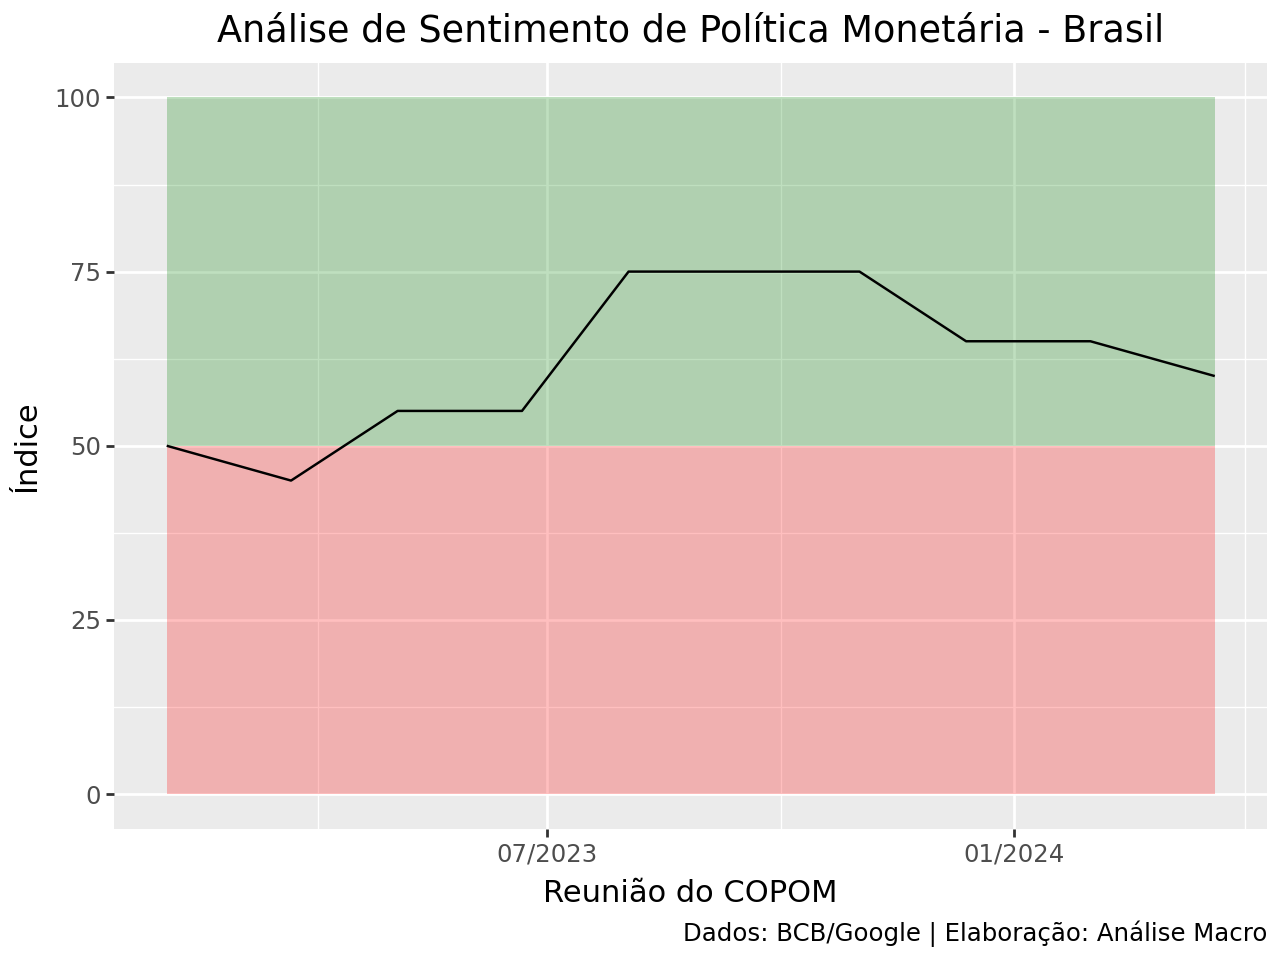

In [7]:
# Análise de sentimento ----
tabela = (
    pd.DataFrame(data = {"data": pd.to_datetime(reuniao), "sentimento": sentimento})
    .assign(sentimento = lambda x: x.sentimento.astype(int))
    )

(
    p9.ggplot(tabela) +
    p9.aes(x = "data", y = "sentimento") +
    p9.geom_ribbon(mapping = p9.aes(ymax = 50, ymin = 0), alpha = 0.25, fill = "red") +
    p9.geom_ribbon(mapping = p9.aes(ymax = 100, ymin = 50), alpha = 0.25, fill = "green") +
    p9.geom_line() +
    p9.scale_x_date(date_breaks = "6 months", date_labels = "%m/%Y") +
    p9.labs(
      title = "Análise de Sentimento de Política Monetária - Brasil",
      x = "Reunião do COPOM",
      y = "Índice",
      caption = "Dados: BCB/Google | Elaboração: Análise Macro"
    )
)